In [1]:
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import norm
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from copulae import *
import itertools
from toolbox import *
from KDEs import *
data = pd.read_csv('../processed_data/btc_future_crix.csv')
data.head()
brr = np.array(data.return_brr)
btc = np.array(data.return_btc)

ecdf_brr = ECDF(data.return_brr)
ecdf_btc = ECDF(data.return_btc)


$$CV(h) = \frac{1}{n^2h}\sum_i\sum_j K\star K\left(\frac{X_j-X_i}{h}\right) - \frac{2}{n(n-1)}\sum_i\sum_{j\neq i}K_h(X_j-X_i)$$

where $K\left(\frac{x}{h}\right)=K_h(x)$ and $ K\star K = \int K(u-v)K(v)dv$ 

(Remark: using symmetric kernel)

from section 3.3.2 of Haerdle's book

In [2]:
kde = KDE(brr, 'Gaussian', bw=0.001)
np.mean(np.log([kde.pdf(r) for r in brr]))

2.0238505032544123

In [588]:
kde = KDE(brr[:300], 'Epanechnikov')

X = np.array(list(itertools.product(kde.data, kde.data)))
input1 = X[:,0] - X[:,1]
_ids = [i+len(kde.data)*i for i in range(len(kde.data))]
input2 = np.delete(input1, _ids) # leave-one-out array X_j - X_i where j!=i

def l_fn(h):
    to_kernel = input2/h
    f = kde.kernel(to_kernel)
    f = f.reshape((len(kde.data),-1))
    f = np.sum(f, axis=1)/((len(kde.data)-1)*h)
    f = np.log(f)
    if len(kde.data) - np.sum(np.isfinite(f))<=2: # Make sure the h is not too small causing make log(0) (allow only two log(0))
        f = np.sum(f[np.isfinite(f)])    
        return f
    else:
        return -5000

toopt = lambda h: -l_fn(h)
scipy.optimize.fmin(toopt,
                    x0=.19)

Optimization terminated successfully.
         Current function value: -571.177346
         Iterations: 19
         Function evaluations: 38


/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


array([0.01758057])

In [564]:
kde_brr = KDE(brr[:300], 'Epanechnikov', 0.01757812)
kde_btc = KDE(btc[:300], 'Epanechnikov', 0.027794)

kde_brr2 = KDE(brr[:300], 'Gaussian', 0.02207031)
kde_btc2 = KDE(btc[:300], 'Gaussian', 0.02175293)

u = ECDF(brr[:300])(brr[:300])
v = ECDF(btc[:300])(btc[:300])

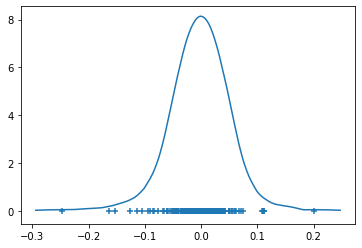

In [590]:
kde_brr = KDE(brr[100:300], 'Epanechnikov', 0.07)

kde_brr.plot_density()
# kde_btc.plot_density()
# kde_brr2.plot_density()
# kde_btc2.plot_density()
# sns.distplot(btc[:300])

In [378]:
NIG = norminvgauss(1,0,0,1)
q_arr = np.linspace(0,1,1000000)
NIG.ppf_sampling_approx(q_arr)

array([-11.15789788, -10.18652469,  -9.81618419, ...,   9.53961528,
         9.74852205,  11.70412881])

In [399]:
u = ECDF(brr[:300])(brr[:300])
v = ECDF(btc[:300])(btc[:300])

In [400]:
C = t_Copula(rho=0.95, nu=10, Law_RS=kde_brr, Law_RF = kde_btc)
C.canonical_calibrate(u,v)
s = C.sample(1000000)
u = kde_brr.cdf(s[:,0])
v = kde_btc.cdf(s[:,1])

Optimization terminated successfully.
         Current function value: 5000.000000
         Iterations: 34
         Function evaluations: 135


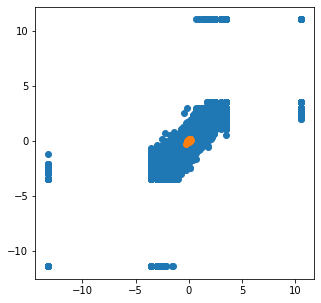

In [402]:
plt.figure(figsize=(5,5))
# plt.scatter(s[:,0],s[:,1])
plt.scatter(NIG.ppf_sampling_approx(u), NIG.ppf_sampling_approx(v))
plt.scatter(kde_brr.data,kde_btc.data)

In [561]:
h=0.01
L = len(kde_btc.data)

def part1(h):
    _in = lambda x: (x-kde_btc.data)/h
    f = lambda x:np.sum(kde_brr.kernel(_in(x)))/(L*h)
    s2 = lambda x: f(x)**2
    
#     fn = lambda x: (np.sum(kde_brr.kernel((x-kde_brr.data)/h))/(L*h))**2
    return scipy.integrate.quad(s2, -np.inf,np.inf)[0]

# part2 = lambda h: 2*np.mean(kde_brr.kernel(input2/h))/h/L
# part2 = lambda h: np.mean(kde_brr.kernel(input2/h))/h
part2 = lambda h: 2*np.sum(kde_btc.kernel(input2/h))/L/L/h
CV = []
p1_arr = []
p2_arr = []
h_arr = np.linspace(0.001,0.04,100)
for h in h_arr:
    p1 = part1(h)
    p2 = part2(h)
    p1_arr.append(p1)
    p2_arr.append(p2)
    CV.append(p1-p2)


/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  # Remove the CWD from sys.path while we load stuff.


In [562]:
h_arr[np.argmin(CV)]

0.006909090909090909

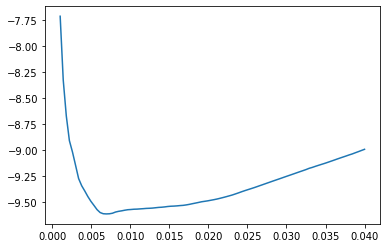

In [563]:
plt.plot(h_arr, CV)
# plt.plot(h_arr, p1_arr)
# plt.plot(h_arr, p2_arr)

In [518]:
K_star_K(input1[1000]/h)

0.2793895104696913

In [519]:
input1[1000]

0.03926576613192084

In [521]:
fn = lambda x: kde_brr.pdf(x/h)**2

scipy.integrate.quad(fn, -np.inf,np.inf)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  This is separate from the ipykernel package so we can avoid doing imports until


(1.782556871856028, 0.000585003889624014)

In [266]:
h=0.0222
to_kernel = input2/h

f = kde.kernel(to_kernel)
f = f.reshape((len(kde.data),-1))
f = np.sum(f, axis=1)/((len(kde.data)-1)*h)
f = np.log(f)
# f = f[np.isfinite(f)]
# f = np.sum(f)   
len(kde.data) - np.sum(np.isfinite(f))

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


2

In [222]:
f = kde.kernel(to_kernel)
# f = f.reshape((len(kde.data),-1))
# f = np.sum(f, axis=1)/((len(kde.data)-1)*h)
np.sum(f)


15480.70113860412

In [253]:
h=0.3
f = kde.kernel(to_kernel)


In [503]:
def K_Uniform(u):
    u = np.abs(u)
    return 0.5*(u <= 1)

def K_Triangle(u):
    u = np.abs(u)
    return (1-u)*(u <= 1)

def K_Epanechnikov(u):
    return (3/4)*(1-u**2)*(np.abs(u)<=1)

def K_Gaussian(u):
    return np.exp(-0.5*u**2)/np.sqrt(2*np.pi)

In [504]:
%%time
def K_star_K(u,K=K_Gaussian):
    fn = lambda v: K(u-v)*K(v)
    return scipy.integrate.quad(fn, -np.inf, np.inf)[0]
K_star_K(1)

CPU times: user 1.17 ms, sys: 4 µs, total: 1.17 ms
Wall time: 1.19 ms


0.21969564473386166

In [4]:
X = np.array(list(itertools.product(brr[:300], brr[:300])))
input1 = X[:,0] - X[:,1]
input2 = input1[input1!=0]

In [129]:
a = []
h=0.001
for i in range(len(brr)):
    a.append(np.log(np.sum(kde.kernel(input2[i*300:(i+1)*300]/h))))

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


In [249]:
MLCV_arr = []
h_arr = np.linspace(0.00000001,0.000001, 1000)
for h in tqdm(h_arr):
    L = len(brr)
    a = np.ones((L))
    for i in range(len(brr)):
        LOO = np.sum(kde.kernel(input2[i*(L-1):(i+1)*(L-1)]/h))
        if LOO == 0:
            LOO = 0.0000000000000000000001
        a[i] = np.log(LOO)
    MLCV = np.sum(a)/L - np.log((L-1)*h)
    MLCV_arr.append(MLCV)

100%|██████████| 1000/1000 [00:08<00:00, 111.25it/s]


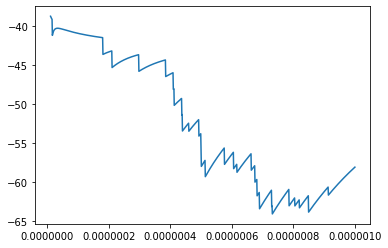

In [250]:
plt.plot(h_arr, MLCV_arr)

In [151]:
f_arr = []
h_arr = np.linspace(0.1,0.2, 50)
for h in tqdm(h_arr):
    f = np.array([kde.kernel(i/h) for i in input2])
    f = f.reshape((300,-1))
    f = np.sum(f, axis=1)/(299*h)
    f = np.sum(np.log(f))
    f_arr.append(f)
# f = np.product(np.sum(f, axis=1))

  0%|          | 0/50 [00:00<?, ?it/s]/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
100%|██████████| 50/50 [00:20<00:00,  2.41it/s]


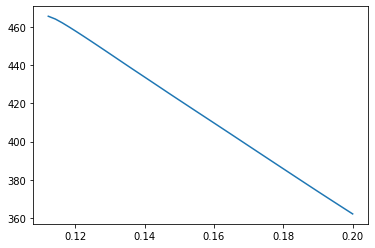

In [152]:
plt.plot(h_arr, f_arr)

In [150]:
f_arr

[-inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf]

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


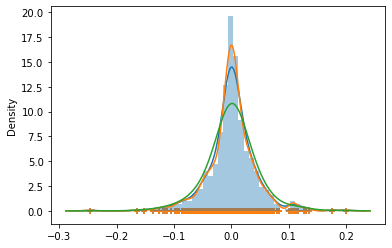

In [44]:
kde1 = KDE(brr, 'Gaussian', bw=bw)
sns.distplot(brr)
kde.plot_density()
kde1.plot_density()

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


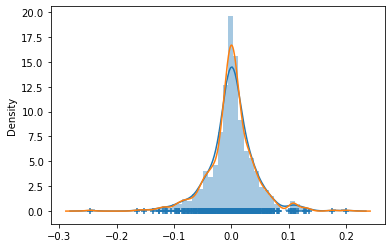

In [39]:
kde = KDE(brr, 'Gaussian')
sns.distplot(brr)
kde.plot_density()

In [277]:
np.product(np.sum(f, axis=1))

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


inf

3.9074146896144993e+214

In [168]:
h=100000
np.log(np.sum(kde.kernel(input2[i*299:(i+1)*299]/h)))

4.781505040182875

In [26]:
from tqdm import tqdm
h=0.001

part1 = []
for x in tqdm(input1):
    part1.append(K_star_K(x/h))

100%|██████████| 90000/90000 [00:43<00:00, 2055.86it/s]


In [31]:
part2 = []
for x in tqdm(input2):
    part2.append(K_Gaussian(x/h))
    

100%|██████████| 89700/89700 [00:00<00:00, 283591.60it/s]


In [5]:
def f(x, data, h, K=K_Gaussian):
    u = lambda x: (x - data)/h
    s = np.sum(K(u(x)))
    return s/(len(data)*h)

In [140]:
uq = np.quantile(data.return_brr, .75)
lq = np.quantile(data.return_brr, .25)

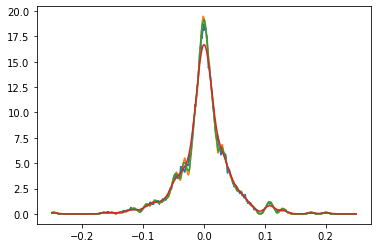

In [142]:
x = np.linspace(-0.25,0.25,1000)
h_rot = 1.06*np.std(data.return_brr)*len(data.return_brr)**(-1/5)
h_brot =  1.06*min(np.std(data.return_brr), (uq-lq)/1.34)*len(data.return_brr)**(-1/5)
h = h_brot
plt.plot(x,[f(x[i],data.return_brr,h, K_Uniform) for i in range(1000)])
plt.plot(x,[f(x[i],data.return_brr,h, K_Triangle) for i in range(1000)])
plt.plot(x,[f(x[i],data.return_brr,h, K_Epanechnikov) for i in range(1000)])
plt.plot(x,[f(x[i],data.return_brr,h, K_Gaussian) for i in range(1000)])

In [144]:
h_brot

0.00732460853848504

In [127]:
import random

def sample_Tri(size, data, h):
    datasample = random.choices(data,k=size)
    u1 = stats.uniform().rvs(size)
    u2 = stats.uniform().rvs(size)
    kernelsample = (u1+u2-1) *h
    return datasample + kernelsample 

def sample_Uni(size, data, h):
    datasample = random.choices(data,k=size)
    u1 = stats.uniform().rvs(size)
    kernelsample = u1*h
    return datasample + kernelsample 

def sample_Epanechnikov(size, data, h):
    datasample = random.choices(data,k=size)
    u1 = stats.uniform().rvs(size)*2-1
    u2 = stats.uniform().rvs(size)*2-1
    u3 = stats.uniform().rvs(size)*2-1
    kernelsample = u3[:]
    i = ( np.abs(u3) >= np.abs(u2) ) & ( np.abs(u3) >= np.abs(u1) )
    kernelsample[i] = u2[i]
    kernelsample = kernelsample*h
    return datasample + kernelsample 

def sample_Gaussian(size, data, h):
    datasample = random.choices(data,k=size)
    kernelsample = stats.norm().rvs(size)*h
    return datasample + kernelsample 

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


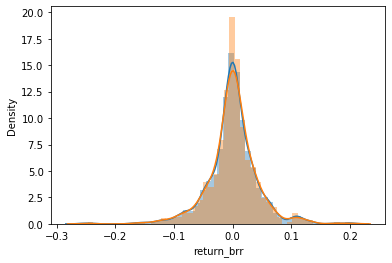

In [153]:
sns.distplot(sample_Gaussian(20000, data.return_brr, h_brot))
sns.distplot(data.return_brr)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


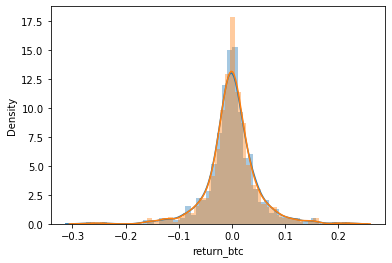

In [36]:
sns.distplot(data.return_btc + trisample*0.01)
sns.distplot(data.return_btc)

In [27]:
y=np.array([f(x[i],data.return_brr,0.01, K_Uniform) for i in range(1000)])

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


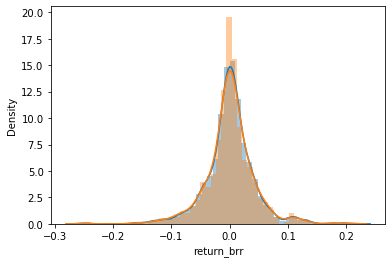

In [2]:
from KDEs import *

kde = KDE(data.return_brr, "Gaussian")
sns.distplot(kde.rvs(10000))
sns.distplot(kde.data)

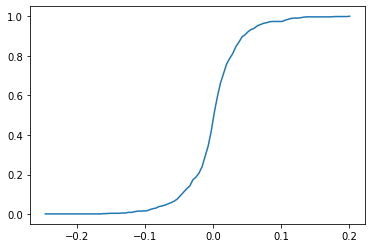

In [10]:
x= np.linspace(min(kde.data),max(kde.data),100)
plt.plot(x,kde.cdf(x))
# plt.plot(x,kde.pdf(x))

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


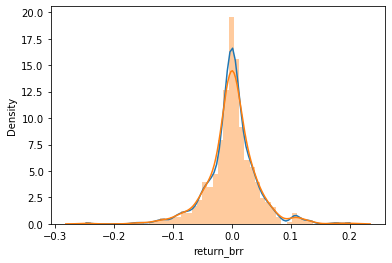

In [11]:
plt.plot(x, [kde.pdf(y) for y in x])
sns.distplot(kde.data)

In [25]:
%%time 
kde.pdf(0)

CPU times: user 1.45 ms, sys: 245 µs, total: 1.7 ms
Wall time: 1.51 ms


16.68037993684482

In [144]:
brr_normalised = (data.return_brr - np.mean(data.return_brr) ) / np.std(data.return_brr)
btc_normalised = (data.return_btc - np.mean(data.return_btc) ) / np.std(data.return_btc)


# def loss(data, df):
#     return np.mean(np.log(stats.t.pdf(data, df=df)))
    
def loss(data, loc, scale, df):
    if df <= 2:
        return -5000
    return np.mean(np.log(stats.t(loc=loc,scale=scale,df=df).pdf(data)))

fn = lambda x: -loss(brr_normalised, x[0],x[1],x[2])

result = scipy.optimize.fmin(fn, (0,1,10))
print(result)

Optimization terminated successfully.
         Current function value: 1.307527
         Iterations: 111
         Function evaluations: 194
[0.01656656 0.55917455 2.29039561]


In [159]:

m = np.mean(data.return_brr)
s = np.std(data.return_brr)

brr_normalised = (data.return_brr -m  ) / s
btc_normalised = (data.return_btc - np.mean(data.return_btc) ) / np.std(data.return_btc)

# def loss(data, df):
#     return np.mean(np.log(stats.t.pdf(data, df=df)))
    
def loss(data, loc, scale, df):
    if df <= 2:
        return -5000
    return np.mean(np.log(stats.t(loc=loc,scale=scale,df=df).pdf(data)))

fn = lambda x: -loss(brr_normalised, 0,1,x[2])

result = scipy.optimize.fmin(fn, (0,1,10))
print(result)

Optimization terminated successfully.
         Current function value: 1.383171
         Iterations: 44
         Function evaluations: 89
[2.39047753e-04 1.03100422e+00 8.57871269e+00]


/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


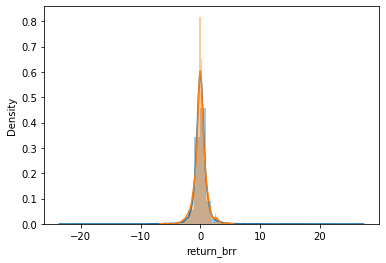

In [145]:
sns.distplot(stats.t(loc=result[0], scale=result[1], df=result[2]).rvs(10000))
sns.distplot(brr_normalised)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


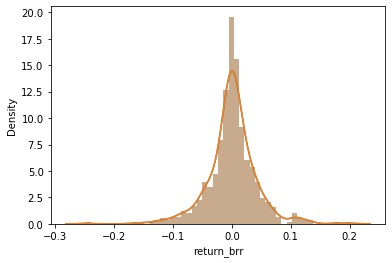

In [160]:
sns.distplot((brr_normalised * s )+ m)
sns.distplot(data.return_brr)

In [161]:
s

0.0417510451863394

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


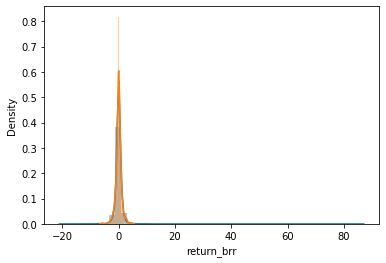

In [140]:
sns.distplot(stats.t(loc=result[0], scale=result[1], df=result[2]).rvs(10000))
sns.distplot(brr_normalised)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


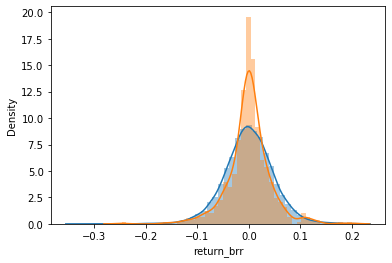

In [42]:
sns.distplot(stats.t(df=8.578).rvs(10000)*np.std(data.return_brr)+np.mean(data.return_brr))
sns.distplot(data.return_brr)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


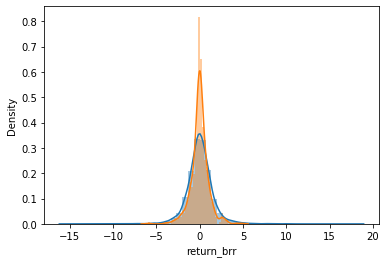

In [57]:
sns.distplot(stats.t(df=3.3).rvs(10000))
sns.distplot(brr_normalised)

In [86]:
def loss(data, loc, scale, df):
    if df <= 2:
        return -5000
    return np.mean(np.log(stats.t(loc=loc,scale=scale,df=df).pdf(data)))

In [87]:
fn = lambda x: -loss(data.return_brr,x[0],x[1],x[2])
result = scipy.optimize.fmin(fn, (0,1,10),
                             maxiter=10000,
                             maxfun=10000)

Optimization terminated successfully.
         Current function value: -1.868504
         Iterations: 215
         Function evaluations: 400


/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


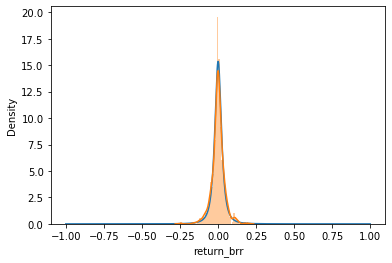

In [95]:
x = np.linspace(-1,1,1000)
plt.plot(x,stats.t(loc=result[0],scale=result[1],df=result[2]).pdf(x))
sns.distplot(data.return_brr)

In [103]:
fitted_t = stats.t(loc=result[0],scale=result[1],df=result[2])

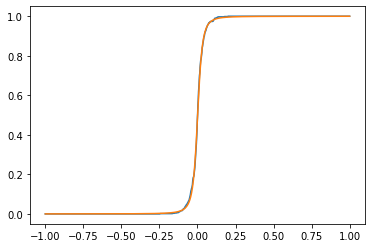

In [104]:
ecdf = ECDF(data.return_brr)
plt.plot(x,ecdf(x))
plt.plot(x,fitted_t.cdf(x))

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


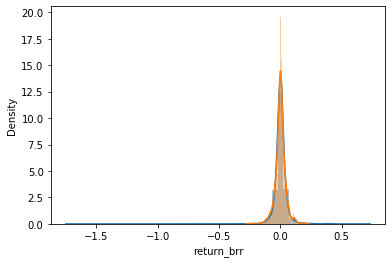

In [109]:
sns.distplot(fitted_t.rvs(10000))
sns.distplot(data.return_brr)

In [131]:
T = stats.t(df=10).rvs(100000)
testing_data = 500 + 100*T

fn = lambda x: -loss(testing_data,x[0],x[1],x[2])
result = scipy.optimize.fmin(fn, (500,100,10),
                             maxiter=10000,
                             maxfun=10000)

Optimization terminated successfully.
         Current function value: 6.125909
         Iterations: 61
         Function evaluations: 112


In [132]:
result

array([500.11745237, 100.33784862,  10.38775963])

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


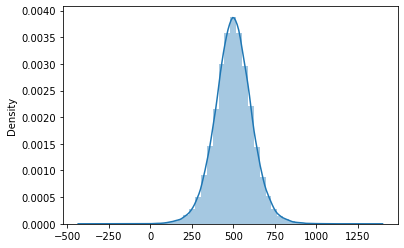

In [130]:
sns.distplot(testing_data)

In [168]:
D = data.return_brr
kdes = [KDE(np.array([d]), 'Gaussian') for d in D]

In [176]:
F = [kdes[i].pdf(0.01) for i in range(len(D))]

In [188]:
kde = KDE(D, 'Gaussian')

In [232]:
u = lambda x: (x - D)/kde.h_brot
K_cdf = norm(scale=kde.h_brot)

x_arr = np.linspace(-0.3,0.3,1000)
results = []

for x in x_arr:
    results.append(np.mean(K_cdf.cdf(u(x))))

ecdf = ECDF(D)

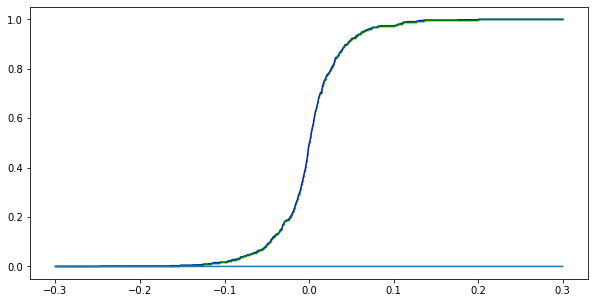

In [235]:
plt.figure(figsize=(10,5))
plt.plot(x_arr, results, 'b-', markersize=1)
plt.plot(x_arr, ecdf(x_arr), 'g.', markersize=1)
plt.plot(x_arr, (results - ecdf(x_arr))**2)

In [234]:
np.sum((results - ecdf(x_arr))**2)

3.2816126124756166e-05

In [313]:
kde_proposal = KDE(D*10, 'Gaussian')
kde_target   = KDE(D, "Gaussian")

In [314]:
sample_proposal = kde_proposal.rvs(20000)

In [315]:
p = np.array([kde_proposal.pdf(sample_proposal[i]) for i in range(len(sample_proposal))])
q = np.array([kde_target.pdf(sample_proposal[i]) for i in range(len(sample_proposal))])

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


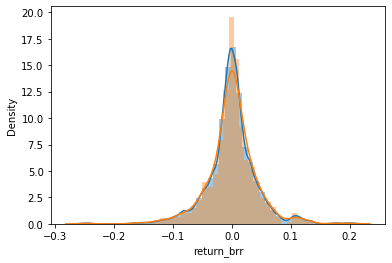

In [316]:
S = np.random.choice(sample_proposal, p=q/p/sum(q/p), size=200000)
sns.distplot(S)
sns.distplot(D)

In [317]:
max(kde_target.rvs(200000))

0.2217694587294419

In [318]:
max(S)

0.22029499805072678

In [319]:
max(D)

0.20025172800119664

In [323]:
min(kde_target.rvs(200000))

-0.27096567781743053

In [324]:
min(S)

-0.2632271376099256

In [325]:
min(D)

-0.24703383936521514

In [ ]:
kde